## Linear Regression for image classification with PyTorch

Credits: \
https://jovian.ai/aakashns/03-logistic-regression

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/Users/u1094325/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


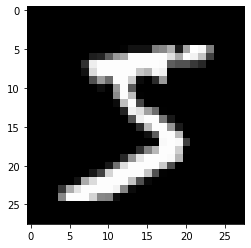

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset. PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. `torchvision.transforms` contains many such predefined functions, and we'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [8]:
import torchvision.transforms as transforms

In [9]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [10]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension is used to keep track of the color channels. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are 3 channels: red, green and blue (RGB).

In [11]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


### Training and Validation Datasets

In [12]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

We can now created data loaders to help us load the data in batches. We'll use a batch size of 128.

In [13]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

### Model

Since `nn.Linear` expects the each training example to be a vector, each `1x28x28` image tensor needs to be flattened out into a vector of size `784 (28*28)`, before being passed into the model.

In [14]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [15]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0284,  0.0113,  0.0141,  ..., -0.0258, -0.0244, -0.0353],
        [ 0.0054, -0.0173, -0.0292,  ...,  0.0069,  0.0329, -0.0138],
        [ 0.0169, -0.0018, -0.0167,  ...,  0.0357,  0.0042,  0.0326],
        ...,
        [ 0.0021,  0.0237, -0.0037,  ...,  0.0347, -0.0014,  0.0194],
        [-0.0017, -0.0218, -0.0063,  ...,  0.0033,  0.0294,  0.0020],
        [ 0.0184,  0.0328, -0.0341,  ..., -0.0118, -0.0226,  0.0197]],
       requires_grad=True)

In [16]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0237, -0.0254, -0.0069, -0.0129, -0.0330, -0.0158, -0.0099, -0.0355,
         0.0337,  0.0066], requires_grad=True)

Our images are of the shape `1x28x28`, but we need them to be vectors of size 784 i.e. we need to flatten them out. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data. To include this additional functionality within our model, we need to define a custom model, by extending the `nn.Module` class from PyTorch

In [17]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer.

In [18]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0083, -0.0021, -0.0299,  ...,  0.0011,  0.0346,  0.0056],
         [-0.0038,  0.0134, -0.0306,  ...,  0.0320, -0.0332,  0.0334],
         [ 0.0159,  0.0130,  0.0026,  ..., -0.0233,  0.0233, -0.0231],
         ...,
         [ 0.0066, -0.0018,  0.0270,  ...,  0.0137, -0.0316,  0.0019],
         [-0.0018, -0.0051,  0.0179,  ...,  0.0208,  0.0339,  0.0266],
         [-0.0166, -0.0055,  0.0070,  ..., -0.0324, -0.0122,  0.0349]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0097,  0.0089, -0.0159,  0.0043,  0.0256,  0.0207, -0.0017, -0.0074,
          0.0273,  0.0159], requires_grad=True)]

In [19]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2555, -0.0367,  0.1905,  0.2261, -0.1945,  0.0038, -0.0754, -0.0099,
          0.1901, -0.0313],
        [ 0.1399,  0.2762,  0.2464,  0.0913, -0.1057, -0.0498, -0.1166,  0.0078,
          0.2616, -0.1155]])


The softmax function is included in the `torch.nn.functional` package, and requires us to specify a dimension along which the softmax must be applied.

In [20]:
import torch.nn.functional as F

# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1213, 0.0906, 0.1137, 0.1178, 0.0774, 0.0943, 0.0871, 0.0930, 0.1136,
         0.0911],
        [0.1067, 0.1223, 0.1187, 0.1016, 0.0834, 0.0882, 0.0825, 0.0935, 0.1205,
         0.0826]])
Sum:  1.0


In [21]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 1, 9, 6, 9, 8, 6, 8, 1, 8, 8, 2, 2, 8, 8, 6, 1, 0, 0, 8, 8, 3, 4, 6,
        9, 8, 5, 8, 4, 2, 2, 8, 8, 2, 8, 8, 0, 7, 8, 2, 2, 2, 8, 7, 1, 8, 2, 6,
        1, 8, 8, 9, 8, 9, 7, 8, 6, 8, 0, 0, 4, 1, 7, 8, 6, 8, 7, 8, 8, 9, 8, 8,
        8, 8, 8, 9, 8, 6, 8, 8, 8, 1, 8, 1, 0, 8, 2, 0, 8, 1, 0, 6, 2, 0, 9, 4,
        5, 8, 8, 8, 6, 2, 8, 6, 4, 2, 8, 8, 8, 7, 6, 7, 4, 8, 8, 8, 8, 8, 8, 3,
        1, 7, 6, 2, 8, 5, 8, 1])
tensor([0.1213, 0.1223, 0.1226, 0.1316, 0.1212, 0.1550, 0.1107, 0.1255, 0.1143,
        0.1311, 0.1412, 0.1145, 0.1156, 0.1374, 0.1381, 0.1259, 0.1131, 0.1195,
        0.1070, 0.1749, 0.1550, 0.1156, 0.1193, 0.1130, 0.1310, 0.1629, 0.1241,
        0.1179, 0.1153, 0.1287, 0.1329, 0.1293, 0.1317, 0.1233, 0.1579, 0.1573,
        0.1124, 0.1259, 0.1236, 0.1302, 0.1255, 0.1247, 0.1410, 0.1128, 0.1320,
        0.1309, 0.1491, 0.1176, 0.1254, 0.1458, 0.1399, 0.1286, 0.1645, 0.1301,
        0.1400, 0.1312, 0.1164, 0.1712, 0.1147, 0.1384, 0.1209, 0.1162, 0.1288,
       

In [22]:
labels

tensor([5, 1, 3, 1, 3, 0, 1, 3, 9, 9, 2, 7, 1, 2, 3, 1, 8, 9, 8, 6, 5, 7, 3, 9,
        0, 0, 9, 7, 3, 1, 7, 9, 7, 7, 0, 6, 1, 7, 2, 5, 5, 7, 8, 6, 7, 9, 8, 1,
        4, 8, 6, 0, 8, 4, 0, 5, 8, 0, 2, 6, 9, 9, 5, 3, 2, 8, 3, 9, 9, 3, 0, 0,
        6, 4, 0, 3, 6, 1, 2, 2, 6, 9, 1, 9, 5, 3, 6, 1, 2, 8, 8, 7, 9, 6, 3, 3,
        5, 6, 7, 5, 1, 9, 0, 1, 1, 1, 1, 4, 1, 3, 1, 3, 7, 6, 6, 0, 0, 4, 9, 5,
        7, 2, 7, 8, 9, 2, 2, 9])

### Evaluation Metric and Loss Function

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
accuracy(outputs, labels)

tensor(0.0547)

In [25]:
loss_fn = F.cross_entropy

# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3698, grad_fn=<NllLossBackward>)


### Training the model

In [26]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [27]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.322314977645874, 'val_acc': 0.08287183195352554}

In [29]:
## Train for 5 epochs:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9539, val_acc: 0.6312
Epoch [1], val_loss: 1.6822, val_acc: 0.7445
Epoch [2], val_loss: 1.4785, val_acc: 0.7759
Epoch [3], val_loss: 1.3244, val_acc: 0.7921
Epoch [4], val_loss: 1.2059, val_acc: 0.8081


In [30]:
## 5 more epochs:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1129, val_acc: 0.8167
Epoch [1], val_loss: 1.0384, val_acc: 0.8236
Epoch [2], val_loss: 0.9774, val_acc: 0.8280
Epoch [3], val_loss: 0.9267, val_acc: 0.8326
Epoch [4], val_loss: 0.8840, val_acc: 0.8358


In [31]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8474, val_acc: 0.8391
Epoch [1], val_loss: 0.8157, val_acc: 0.8410
Epoch [2], val_loss: 0.7880, val_acc: 0.8435
Epoch [3], val_loss: 0.7635, val_acc: 0.8451
Epoch [4], val_loss: 0.7418, val_acc: 0.8472


In [32]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7222, val_acc: 0.8495
Epoch [1], val_loss: 0.7046, val_acc: 0.8514
Epoch [2], val_loss: 0.6886, val_acc: 0.8535
Epoch [3], val_loss: 0.6740, val_acc: 0.8550
Epoch [4], val_loss: 0.6607, val_acc: 0.8565


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

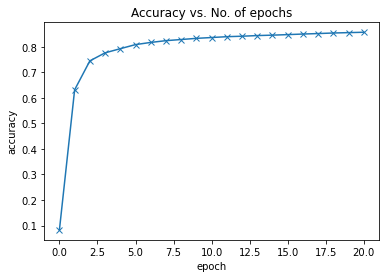

In [33]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

### Testing with individual images

In [34]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


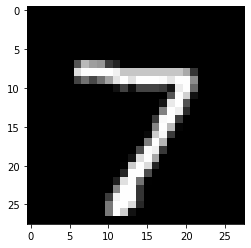

In [35]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [36]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

`img.unsqueeze` simply adds another dimension at the begining of the `1x28x28` tensor, making it a `1x1x28x28` tensor, which the model views as a batch containing a single image.

In [38]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


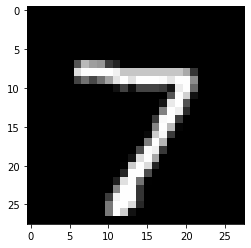

In [39]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [40]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6388569474220276, 'val_acc': 0.861132800579071}

### Saving and loading the model

In [41]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [42]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 1.9862e-02,  7.9617e-03,  1.8048e-02,  ...,  2.6265e-02,
                        2.8510e-02, -1.5775e-02],
                      [ 1.8872e-03,  3.5121e-02,  1.7515e-02,  ...,  1.0292e-02,
                        2.8281e-02,  7.9140e-03],
                      [-5.6099e-03,  6.9677e-04, -8.6186e-03,  ...,  3.0285e-03,
                       -2.4729e-02,  9.1767e-04],
                      ...,
                      [-1.2073e-02,  9.3495e-03, -2.7398e-02,  ..., -2.0053e-02,
                        2.7167e-02,  2.7191e-02],
                      [ 8.0229e-03,  2.3412e-02,  2.5715e-02,  ..., -1.8835e-03,
                        3.2801e-02, -7.0600e-03],
                      [ 1.8568e-03, -1.4662e-02,  2.1652e-02,  ..., -4.3947e-05,
                        3.3690e-02,  3.2620e-02]])),
             ('linear.bias',
              tensor([-0.0676,  0.1066, -0.0148, -0.0209,  0.0085,  0.0105, -0.0359,  0.0425,
                      -0.1183,

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict method`.

In [44]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 1.9862e-02,  7.9617e-03,  1.8048e-02,  ...,  2.6265e-02,
                        2.8510e-02, -1.5775e-02],
                      [ 1.8872e-03,  3.5121e-02,  1.7515e-02,  ...,  1.0292e-02,
                        2.8281e-02,  7.9140e-03],
                      [-5.6099e-03,  6.9677e-04, -8.6186e-03,  ...,  3.0285e-03,
                       -2.4729e-02,  9.1767e-04],
                      ...,
                      [-1.2073e-02,  9.3495e-03, -2.7398e-02,  ..., -2.0053e-02,
                        2.7167e-02,  2.7191e-02],
                      [ 8.0229e-03,  2.3412e-02,  2.5715e-02,  ..., -1.8835e-03,
                        3.2801e-02, -7.0600e-03],
                      [ 1.8568e-03, -1.4662e-02,  2.1652e-02,  ..., -4.3947e-05,
                        3.3690e-02,  3.2620e-02]])),
             ('linear.bias',
              tensor([-0.0676,  0.1066, -0.0148, -0.0209,  0.0085,  0.0105, -0.0359,  0.0425,
                      -0.1183,

In [45]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6388569474220276, 'val_acc': 0.861132800579071}